# Feasability study for products classification

In this notebook we will evaluate the possibility to have a clusterization by text. \
We aim to create a model that will cluster the products in the same way they are naturally clusturized. This would mean that the classification of product can be done by machine learning. 

In [66]:
# classic Librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import shutil

# NLTK imports
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# sklearn import 
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

# librairies for NLP
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

import gensim

# Bert
import transformers
from transformers import TFAutoModel
from transformers import AutoTokenizer

# USE
import tensorflow_hub as hub

# image imports
from matplotlib.image import imread
import PIL
from PIL import Image, ImageFilter, ImageEnhance

import cv2

In [67]:
data = pd.read_csv("data/flipkart_com-ecommerce_sample_1050.csv")
data.shape

(1050, 15)

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

Now the question is : what categories will we use to clusturize products by type ? Surely we will need to focus on text description, name, and the like

The "product_name" category seems essential \
The "category_tree" looks very promising due to its name \
The "description" sounds good, but it depends on what _type_ of description we are talking about. A commercial description could alter our results \
The "product_specifications" looks interesting as well. A dictionnary in which the function ("key"=>"Designed For") is given sounds interesting

In [70]:
data.product_name.loc[0]

'Elegance Polyester Multicolor Abstract Eyelet Door Curtain'

By observing the "product_category_tree" columns, we face another question : how far do we want to be specific ? The general category ? Or the n-x subcategory ? \
We will use the general category only

In [72]:
data['general_category'] = data['product_category_tree'].map(lambda x: x.strip('["]').split(' >> ')[0])
data['general_category'].head(5)

0    Home Furnishing
1          Baby Care
2          Baby Care
3    Home Furnishing
4    Home Furnishing
Name: general_category, dtype: object

In [73]:
data['general_category'].nunique()

7

We have a total of 7 categories

### The client wants an analysis on image and _description_
We will therefore base our feasability research on the "description" category \
Seems foolish not to include the name tho ...

In [76]:
data.description

0       Key Features of Elegance Polyester Multicolor ...
1       Specifications of Sathiyas Cotton Bath Towel (...
2       Key Features of Eurospa Cotton Terry Face Towe...
3       Key Features of SANTOSH ROYAL FASHION Cotton P...
4       Key Features of Jaipur Print Cotton Floral Kin...
                              ...                        
1045    Oren Empower Extra Large Self Adhesive Sticker...
1046    Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047    Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048    Buy Wallmantra Medium Vinyl Sticker Sticker fo...
1049    Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...
Name: description, Length: 1050, dtype: object

## Text pre_treatment

In [78]:
# nltk package installer
# nltk.download('all')

In [79]:
# To understand what we are dealing with, let's see the first description
desc = data.description[0]
desc

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

In [80]:
'''
# let's define a function to clean the sentence
def sentence_cleaner(sentence):
    sentence_cleaned = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ').replace('(', ' ').replace(')', ' ')
    return sentence_cleaned

x = sentence_cleaner(desc)
x
# The second approach with RegExp seems mor efficient than this one
'''

"\n# let's define a function to clean the sentence\ndef sentence_cleaner(sentence):\n    sentence_cleaned = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ').replace('(', ' ').replace(')', ' ')\n    return sentence_cleaned\n\nx = sentence_cleaner(desc)\nx\n# The second approach with RegExp seems mor efficient than this one\n"

In [81]:
# define a RegExp to tokenize only alphanumerics
tokenizer = nltk.RegexpTokenizer(r'\w+')
list_of_words = tokenizer.tokenize(desc)
#list_of_words

In [82]:
# lower all characters
lowered_list = [w.lower() for w in list_of_words]
#lowered_list
#len(lowered_list)

In [83]:
# stopwords exploration
len(nltk.corpus.stopwords.words('english'))

179

In [84]:
# stopwords suppression
def stop_word_filter(list_words) :
    stop_w = nltk.corpus.stopwords.words('english')
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

In [85]:
filtered_list = stop_word_filter(lowered_list)
#filtered_list
#len(filtered_list)

Description has been normalized by suppressing anything other than alphanumerics, lowering case, suppressing stopwords

### Stem / lemmat
Now it's time to stem / lemmatize our list of words

General opinion is that Stemming outperforms Lemmatization. \
We will prepare both anyway and retain the best-performing one

In [88]:
def lemmat(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

In [89]:
lemmat_list = lemmat(filtered_list)
#lemmat_list
#len(lemmat_list)

In [90]:
def stemmer(list_words) : 
    stem = PorterStemmer()
    stem_w = [stem.stem(w) for w in list_words]
    return stem_w

In [91]:
stem_list = stemmer(filtered_list)
#stem_list

In [92]:
transf_desc_text = ' '.join(stem_list)
transf_desc_text

'key featur eleg polyest multicolor abstract eyelet door curtain floral curtain eleg polyest multicolor abstract eyelet door curtain 213 height pack price 899 curtain enhanc look interior curtain made 100 high qualiti polyest fabric featur eyelet style stitch metal ring make room environ romant love curtain ant wrinkl anti shrinkag eleg appar give home bright modernist appeal design surreal attent sure steal heart contemporari eyelet valanc curtain slide smoothli draw apart first thing morn welcom bright sun ray want wish good morn whole world draw close even creat special moment joyou beauti given sooth print bring home eleg curtain softli filter light room get right amount sunlight specif eleg polyest multicolor abstract eyelet door curtain 213 height pack gener brand eleg design door type eyelet model name abstract polyest door curtain set model duster25 color multicolor dimens length 213 box number content sale packag pack sale packag curtain bodi design materi polyest'

In [93]:
# Define a treatment function that will be usable on the whole dataset

def cleaning_description_stemmed(description) :
    # Tools used reminder :
    # tokenizer = nltk.RegexpTokenizer(r'\w+')
    # stop_w = nltk.corpus.stopwords.words('english')
    # lemmatizer = WordNetLemmatizer()
    # stem = PorterStemmer()
    
    list_of_words = tokenizer.tokenize(description)
    lowered_list = [w.lower() for w in list_of_words]
    filtered_list = stop_word_filter(lowered_list)
    #lemmat_list = lemmat(filtered_list)
    stemmed_list = stemmer(filtered_list)
    transformed_desc = ' '.join(stemmed_list)

    return transformed_desc

In [94]:
# Create a new column with all description cleaned

data['cleaned_desc_stem'] = data['description'].apply(lambda x : cleaning_description_stemmed(x))

In [95]:
data['description'][1049]

'Buy Uberlyfe Large Vinyl Sticker for Rs.595 online. Uberlyfe Large Vinyl Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.'

In [96]:
data['cleaned_desc_stem'][1049]

'buy uberlyf larg vinyl sticker 595 onlin uberlyf larg vinyl sticker best price free ship cash deliveri genuin product day replac guarante'

lemmat => tfidf + stem => tfidf \
Faire les deux approches séparement pour comparer les résultats

## Bag Of Word

In [99]:
# How important is the bag of word ?

x = data['cleaned_desc_stem'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", x)

max length bow :  0       152
1        62
2       154
3       112
4       150
       ... 
1045    224
1046    152
1047     30
1048     24
1049     22
Name: cleaned_desc_stem, Length: 1050, dtype: int64


In [100]:
# create bag of words (CountVectorizer et Tf-idf)

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

cv_fit = cvect.fit(data['cleaned_desc_stem'])
ctf_fit = ctf.fit(data['cleaned_desc_stem'])

cv_transform = cvect.transform(data['cleaned_desc_stem'])  
ctf_transform = ctf.transform(data['cleaned_desc_stem'])  

In [101]:
cv_transform

<1050x4679 sparse matrix of type '<class 'numpy.int64'>'
	with 33327 stored elements in Compressed Sparse Row format>

In [102]:
ctf_transform

<1050x4679 sparse matrix of type '<class 'numpy.float64'>'
	with 33327 stored elements in Compressed Sparse Row format>

We obviously have a lot of different words throughout the entire corpus of description \
We may want to reduce this number

### Fitting on the name to reduce number of words seen during training

In [105]:
# Clean the product_name first
data['cleaned_name'] = data['product_name'].apply(lambda x : cleaning_description_stemmed(x))

# Create a feature composed of name and description
data['to_bow_clean'] = data['cleaned_name'] +' '+ data['cleaned_desc_stem']

In [106]:
cv_fit_2 = cvect.fit(data['cleaned_name'])
ctf_fit_2 = ctf.fit(data['cleaned_name'])

cv_transform_2 = cvect.transform(data['to_bow_clean'])  
ctf_transform_2 = ctf.transform(data['to_bow_clean'])

In [107]:
cv_transform_2

<1050x2064 sparse matrix of type '<class 'numpy.int64'>'
	with 17795 stored elements in Compressed Sparse Row format>

In [108]:
ctf_transform_2

<1050x2064 sparse matrix of type '<class 'numpy.float64'>'
	with 17795 stored elements in Compressed Sparse Row format>

We reduced the number of words seen during training from 4676 to 2064

tester ACP + TSNE sur BoW \
tester TSNE solo \
l'ACP est justifiable si la TSNE est trop longue 

### PCA

In [112]:
# PCA to reduce dimensions
pca = PCA(svd_solver='arpack')
pca.fit(ctf_transform_2)

PCA(svd_solver='arpack')

In [113]:
# how many components needed to explain 80% of variance
x = (pca.explained_variance_ratio_*100).round(2).cumsum()
y = np.where(x>=80)[0][0]
y

368

PCA tells us that 80% of variance is explained by 369 features \
We can now reduce to this amount of features

In [115]:
pca = PCA(n_components=y+1, svd_solver='arpack')
reduced_ctf_transform_2 = pca.fit_transform(ctf_transform_2)

In [116]:
reduced_ctf_transform_2.shape

(1050, 369)

### TSNE

In [118]:
# T-SNE to reduce dimensions

tsne = TSNE(init='random')

embedded_ctf_transform_2 = tsne.fit_transform(ctf_transform_2)
embedded_ctf_transform_2.shape

C:\Users\kanam\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\kanam\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


(1050, 2)

In [119]:
embedded_ctf_transform_2

array([[ -8.977878,  23.405804],
       [-34.21305 ,  28.927446],
       [-30.588268,  29.617142],
       ...,
       [-25.745283, -20.378128],
       [-25.1721  , -17.846037],
       [-25.78331 , -19.584114]], dtype=float32)

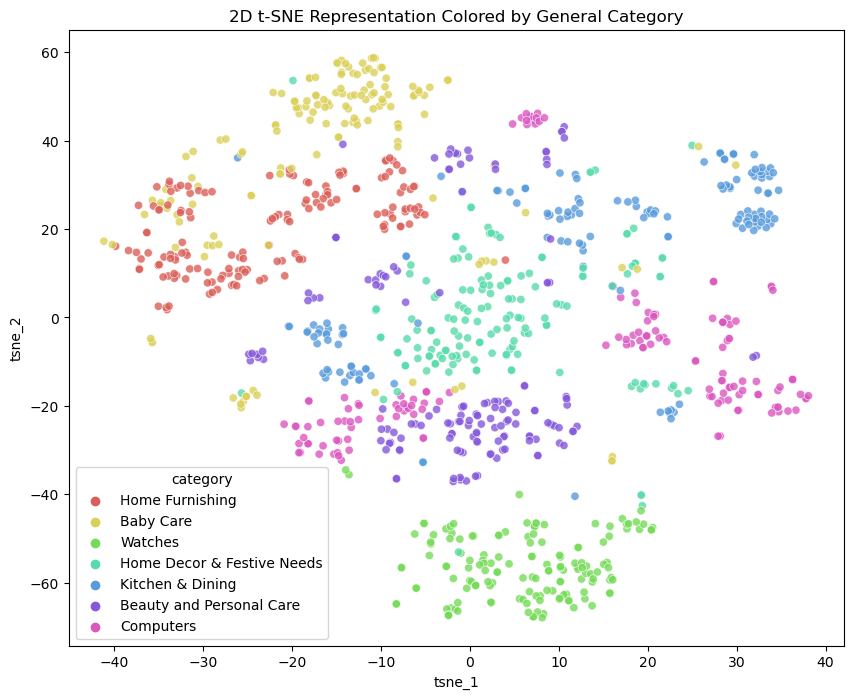

In [120]:
general_categories = data['general_category']

df_real_categories = pd.DataFrame({
    'tsne_1': embedded_ctf_transform_2[:, 0],
    'tsne_2': embedded_ctf_transform_2[:, 1],
    'category': general_categories
})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='tsne_1', y='tsne_2', 
    hue='category',
    palette=sns.color_palette('hls', len(df_real_categories['category'].unique())),
    data=df_real_categories,
    legend='full',
    alpha=0.8
)
plt.title('2D t-SNE Representation Colored by General Category')
plt.show()

## Clustering via K-means

In [122]:
kmeans = KMeans(n_clusters=7, n_init=100 ,random_state=42, init='k-means++')
kmeans.fit(embedded_ctf_transform_2)

C:\Users\kanam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


KMeans(n_clusters=7, n_init=100, random_state=42)

In [123]:
data['clustering'] = kmeans.predict(embedded_ctf_transform_2)
data['clustering'].head()

0    0
1    4
2    4
3    0
4    0
Name: clustering, dtype: int32

In [124]:
df_clustering = pd.DataFrame({
    'tsne_1': embedded_ctf_transform_2[:, 0],
    'tsne_2': embedded_ctf_transform_2[:, 1],
    'clusters': data['clustering']
})

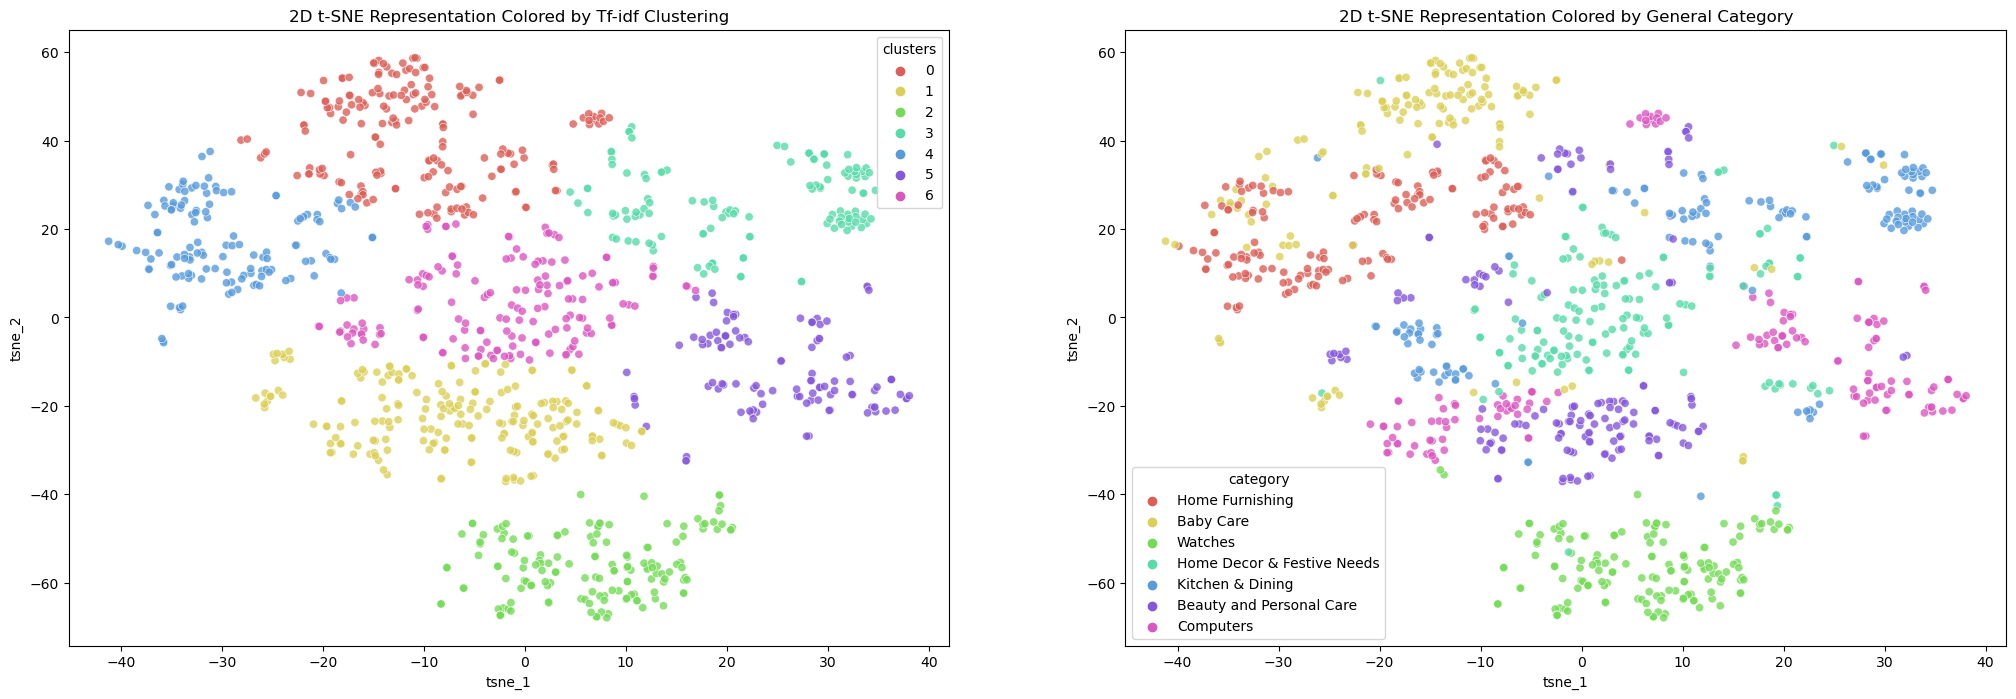

In [125]:
# Compare Tf-idf clustering against true categories
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

sns.scatterplot(
    ax=ax[1],
    x='tsne_1', y='tsne_2',
    hue='category',
    palette=sns.color_palette('hls', len(df_real_categories['category'].unique())),
    data=df_real_categories,
    legend='full',
    alpha=0.8
)
ax[1].set_title('2D t-SNE Representation Colored by General Category')

sns.scatterplot(
    ax=ax[0],
    x='tsne_1', y='tsne_2',
    hue='clusters',
    palette=sns.color_palette('hls', len(df_clustering['clusters'].unique())),
    data=df_clustering,
    legend='full',
    alpha=0.8
)
ax[0].set_title('2D t-SNE Representation Colored by Tf-idf Clustering')


plt.show()

In [126]:
ari_clustering = adjusted_rand_score(data['general_category'], data['clustering'])

print('Similarity score :', ari_clustering)

0.4479023332415696


ARI of 0.48 (drops to 0.25 when t-sne is performed on PCAd data) \
To be precise : it is unstable (sometimes 0.48, sometimes 0.35) \
It seems unsatisfaying to validate an automated classification. \
Maybe text features weren't prepared well enough ? Tf-IDF ill adapted to our case ?

## Advanced techniques : Word2Vec, BERT, USE

### Word2Vec

In [175]:
# need to rework from data['to_bow_clean']
data['bow_cleaned_list'] = data['to_bow_clean'].to_list()

In [177]:
sentences = data['bow_cleaned_list']
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [179]:
# params
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=50
maxlen=20

In [183]:
# Create and train Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)

w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print(f"Vocabulary size: {len(w2v_words)}")
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4030
Word2Vec trained


In [185]:
# Tokenization

print("Fitting Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print(f"Number of unique words: {num_words}" )

Fitting Tokenizer ...
Number of unique words: 4031


In [187]:
# Eembedding Matrix

print("Creating Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print(f"Embedding matrix : {embedding_matrix.shape}")

Creating Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix : (4031, 300)


In [189]:
# Model init

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

C:\Users\kanam\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 20, 300)             │       1,209,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 300)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,300 (4.61 MB)

 Trainable params: 1,209,300 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

In [191]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


(1050, 300)

In [193]:
# Clustering with embedding

kmeans = KMeans(n_clusters=7, n_init=100 ,random_state=42, init='k-means++')
kmeans.fit(embeddings)
data['clustering_w2v'] = kmeans.predict(embeddings)

C:\Users\kanam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Similarity score : 0.28088973036745646


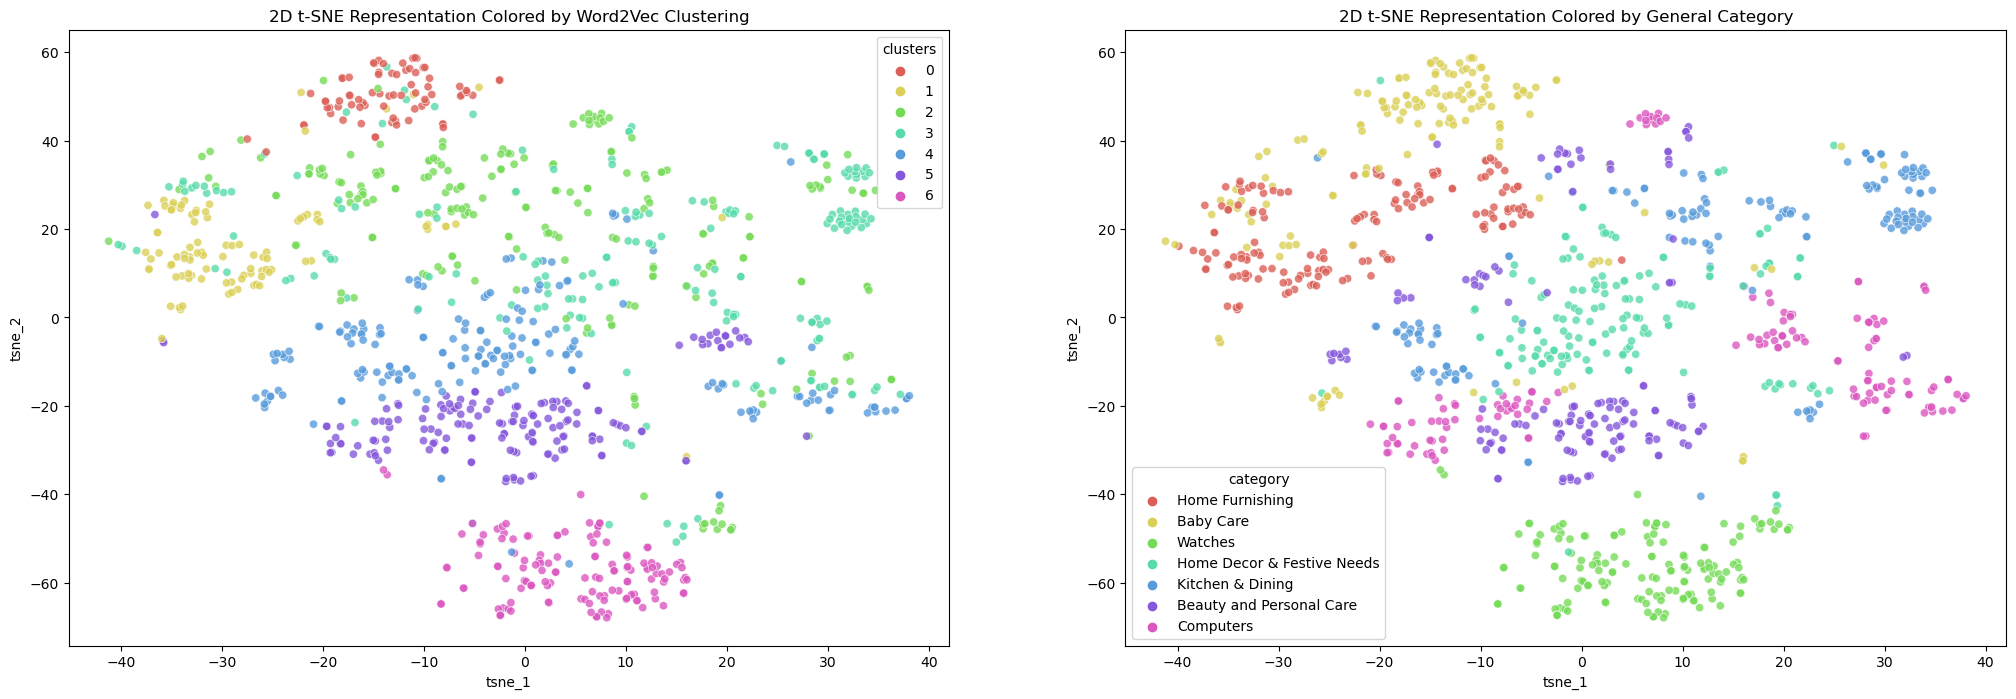

In [205]:
# prepare Word2Vec df for visualization
df_clustering = pd.DataFrame({
    'tsne_1': embedded_ctf_transform_2[:, 0],
    'tsne_2': embedded_ctf_transform_2[:, 1],
    'clusters': data['clustering_w2v']
})

# Compare Word2Vec clustering against true categories
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

sns.scatterplot(
    ax=ax[1],
    x='tsne_1', y='tsne_2',
    hue='category',
    palette=sns.color_palette('hls', len(df_real_categories['category'].unique())),
    data=df_real_categories,
    legend='full',
    alpha=0.8
)
ax[1].set_title('2D t-SNE Representation Colored by General Category')

sns.scatterplot(
    ax=ax[0],
    x='tsne_1', y='tsne_2',
    hue='clusters',
    palette=sns.color_palette('hls', len(df_clustering['clusters'].unique())),
    data=df_clustering,
    legend='full',
    alpha=0.8
)
ax[0].set_title('2D t-SNE Representation Colored by Word2Vec Clustering')


plt.show()

In [201]:
print('Similarity score :',adjusted_rand_score(data['general_category'], data['clustering_w2v']))

Similarity score : 0.28088973036745646


Word2Vec is WORSE than tf-idf ???

### BERT

In [207]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.17.0
2.17.0
Num GPUs Available:  0
False


In [209]:
# Sentences prep function
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Feature creation function (with huggingface and TF as options)
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids,
                                 "input_mask" : attention_mask,
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1, 2)
    print(f"It took : {time2} seconds")
     
    return features_bert, last_hidden_states_tot

In [211]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data['to_bow_clean'].to_list()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [97]:
# Alternative method with usage of uncleaned sentences, as BERT has a cleaner
# data['name_n_desc'] = data['product_name'] +' '+ data['description']
# sentences = data['name_n_desc'].to_list()

In [213]:
# Features creation
# 102 secs to run

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 1s 1s/step
It took : 130.49 seconds


In [215]:
BERT_embeddings = tsne.fit_transform(features_bert)
BERT_embeddings.shape

(1050, 2)

In [217]:
kmeans.fit(BERT_embeddings)
data['clustering_BERT'] = kmeans.predict(BERT_embeddings)

C:\Users\kanam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [218]:
# prepare BERT visualisation
df_clustering_BERT = pd.DataFrame({
    'tsne_1': BERT_embeddings[:, 0],
    'tsne_2': BERT_embeddings[:, 1],
    'clusters': data['clustering_BERT']
})

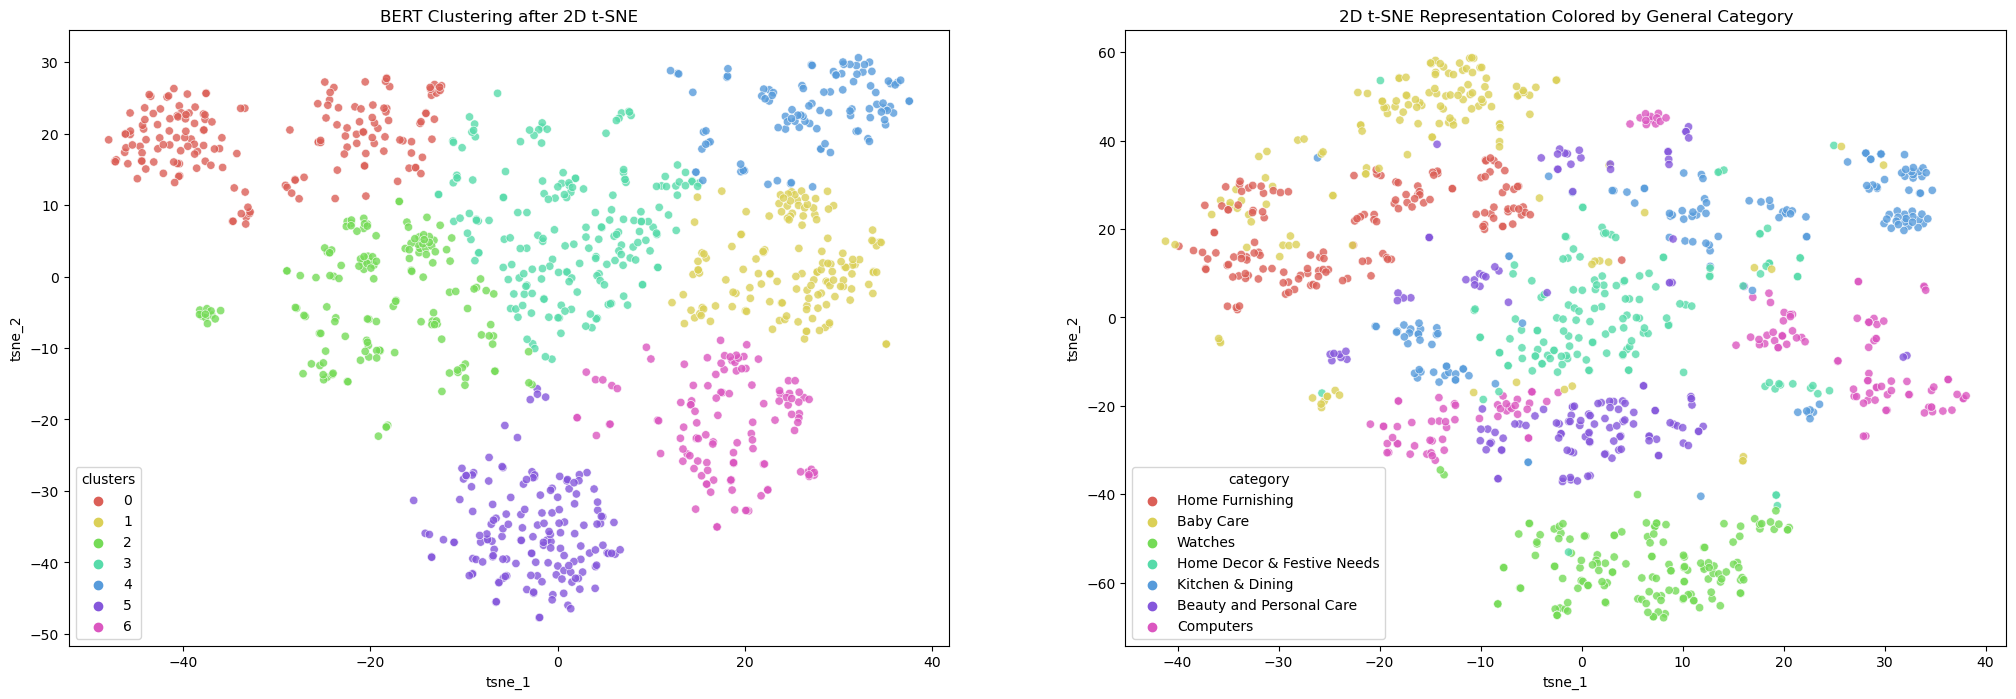

In [219]:
# Compare BERT clustering against true categories
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

sns.scatterplot(
    ax=ax[1],
    x='tsne_1', y='tsne_2',
    hue='category',
    palette=sns.color_palette('hls', len(df_real_categories['category'].unique())),
    data=df_real_categories,
    legend='full',
    alpha=0.8
)
ax[1].set_title('2D t-SNE Representation Colored by General Category')

sns.scatterplot(
    ax=ax[0],
    x='tsne_1', y='tsne_2',
    hue='clusters',
    palette=sns.color_palette('hls', len(df_clustering_BERT['clusters'].unique())),
    data=df_clustering_BERT,
    legend='full',
    alpha=0.8
)
ax[0].set_title('BERT Clustering after 2D t-SNE')


plt.show()

In [220]:
print('Similarity score :',adjusted_rand_score(data['general_category'], data['clustering_BERT']))

Similarity score : 0.4313648152947712


Better than Word2Vec, worse than tf-idf

### USE

In [327]:
# Load the Universal Sentence Encoder
use_model = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")

# NOW raises a problem ??? 
# Switched to kaggle loading instead of google

In [333]:
# USE embeddings function
def get_use_embedding(text, model):
    return model([text]).numpy().squeeze()

# Apply USE to dataset
data['use_embeddings'] = data['to_bow_clean'].apply(lambda x: get_use_embedding(x, use_model))

# Use the embeddings for clustering
X = np.stack(data['use_embeddings'].values)
kmeans = KMeans(n_clusters=7, random_state=42)
#data['use_clustering'] = kmeans.fit_predict(X)

In [335]:
# t-SNE on X
USE_embeddings = tsne.fit_transform(X)
#USE_embeddings.shape

data['use_clustering'] = kmeans.fit_predict(X)

C:\Users\kanam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [337]:
# Reset variables for USE visualisation
df_clustering_USE = pd.DataFrame({
    'tsne_1': USE_embeddings[:, 0],
    'tsne_2': USE_embeddings[:, 1],
    'clusters': data['use_clustering']
})

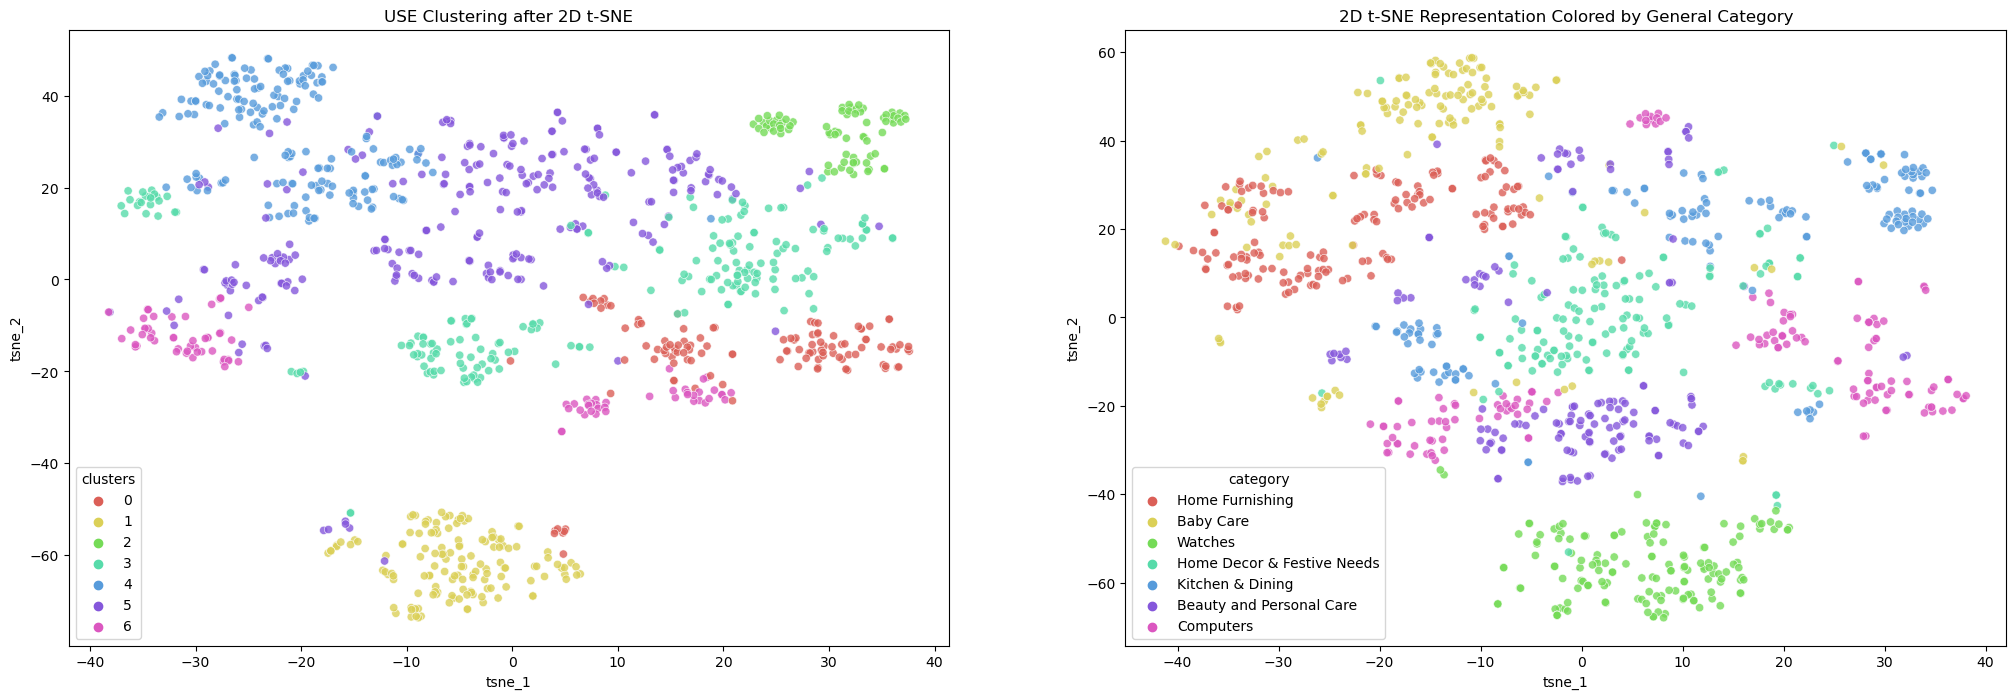

In [339]:
# Compare USE clustering against true categories
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

sns.scatterplot(
    ax=ax[1],
    x='tsne_1', y='tsne_2',
    hue='category',
    palette=sns.color_palette('hls', len(df_real_categories['category'].unique())),
    data=df_real_categories,
    legend='full',
    alpha=0.8
)
ax[1].set_title('2D t-SNE Representation Colored by General Category')

sns.scatterplot(
    ax=ax[0],
    x='tsne_1', y='tsne_2',
    hue='clusters',
    palette=sns.color_palette('hls', len(df_clustering_USE['clusters'].unique())),
    data=df_clustering_USE,
    legend='full',
    alpha=0.8
)
ax[0].set_title('USE Clustering after 2D t-SNE')


plt.show()

In [341]:
# Evaluate the ARI
ari_use_clustering = adjusted_rand_score(data['general_category'], data['use_clustering'])
print('Similarity score :',ari_use_clustering)

Similarity score : 0.3725344159174538


around Word2Vec performances

It really seems that classification via description is not enough in itself \
Tf-idf and BERT produced better results, but nothing over 0.5

## Image based classification

### Working on a separate dataset

In [237]:
# Create a subdataset with categories and images only
data_img = pd.DataFrame()
data_img['image'] = data['image']
data_img['category'] = data['general_category']

data_img['img_path'] = [os.path.join('data/Images/', filename) for filename in data_img['image']]
data_img.head()

image         category  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3  d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   

                                           img_path  
0  data/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  
1  data/Images/7b72c92c2f6c40268628ec5f14c6d590.jpg  
2  data/Images/64d5d4a258243731dc7bbb1eef49ad74.jpg  
3  data/Images/d4684dcdc759dd9cdf41504698d737d8.jpg  
4  data/Images/6325b6870c54cd47be6ebfbffa620ec7.jpg

In [238]:
data_img.groupby("category").count()

image  img_path
category                                   
Baby Care                     150       150
Beauty and Personal Care      150       150
Computers                     150       150
Home Decor & Festive Needs    150       150
Home Furnishing               150       150
Kitchen & Dining              150       150
Watches                       150       150

### Treating one image : transformations

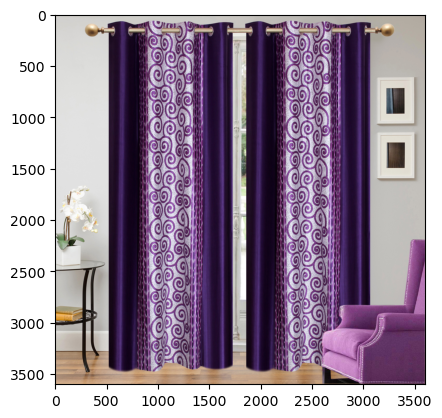

In [240]:
# with PILLOW
img = Image.open(data_img['img_path'][0]) 

#img.show() => open image navigator by default
plt.imshow(img)
plt.show()

In [241]:
# print out image size (pixels)
w, h = img.size
print(f"Width : {w} px", f"Height : {h} px")

Width : 3600 px Height : 3600 px


In [242]:
# Quantization mode
print("Pixel Quantization : ", img.mode)

# Get the value of specific pixel
px_value = img.getpixel((20,100))
print("Pixel (20,100) value : ", px_value)

Pixel Quantization :  RGB
Pixel (20,100) value :  (211, 210, 206)


In [243]:
# Pixels value matrix
mat = np.array(img)
#print(mat)
# Print out Matrix dimension
print("Pixel Matrix dimensions : {}".format(mat.shape))

Pixel Matrix dimensions : (3600, 3600, 3)


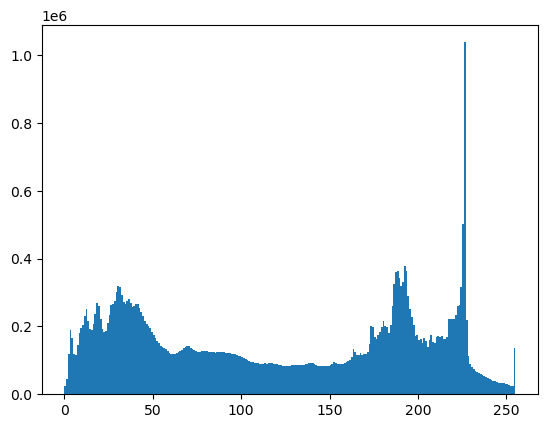

In [244]:
# Histogram
# to normalise hist : arg density=True in plt.hist
# to get cumulated hist : arg cumulative=True
n, bins, patches = plt.hist(mat.flatten(), bins=range(256))
plt.show()
# maybe use flatten('F') to use Fortran flattener ? 
#tried, no sensible improvement

Very high concentration of darker color, which is expected due to high presence of purple

PILLOW :
equalizer DONE, filtrage bruit, contraste, floutage \
Use the ImageOps modules https://pillow.readthedocs.io/en/latest/reference/ImageOps.html 

#### Applying transformations

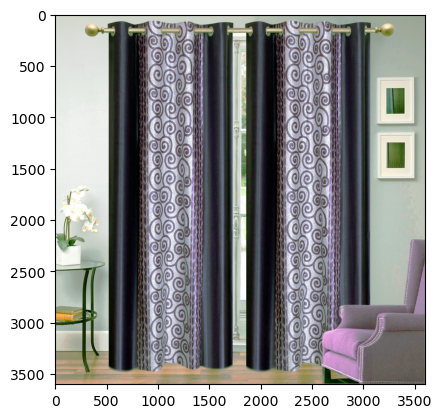

In [248]:
# Equalizer

img2 = PIL.ImageOps.equalize(img)
plt.imshow(img2)
plt.show()

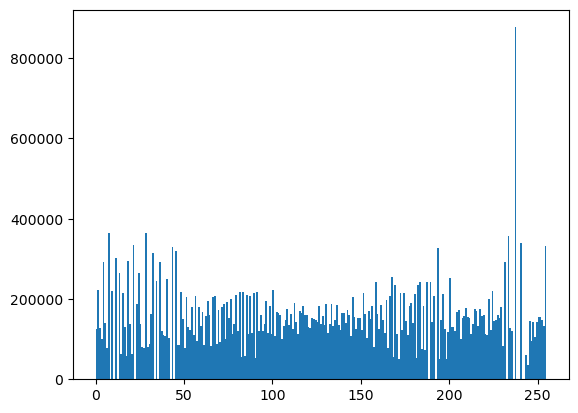

In [249]:
#Equalized hist

mat2 = np.array(img2)
n, bins, patches = plt.hist(mat2.flatten(), bins=range(256))
plt.show()

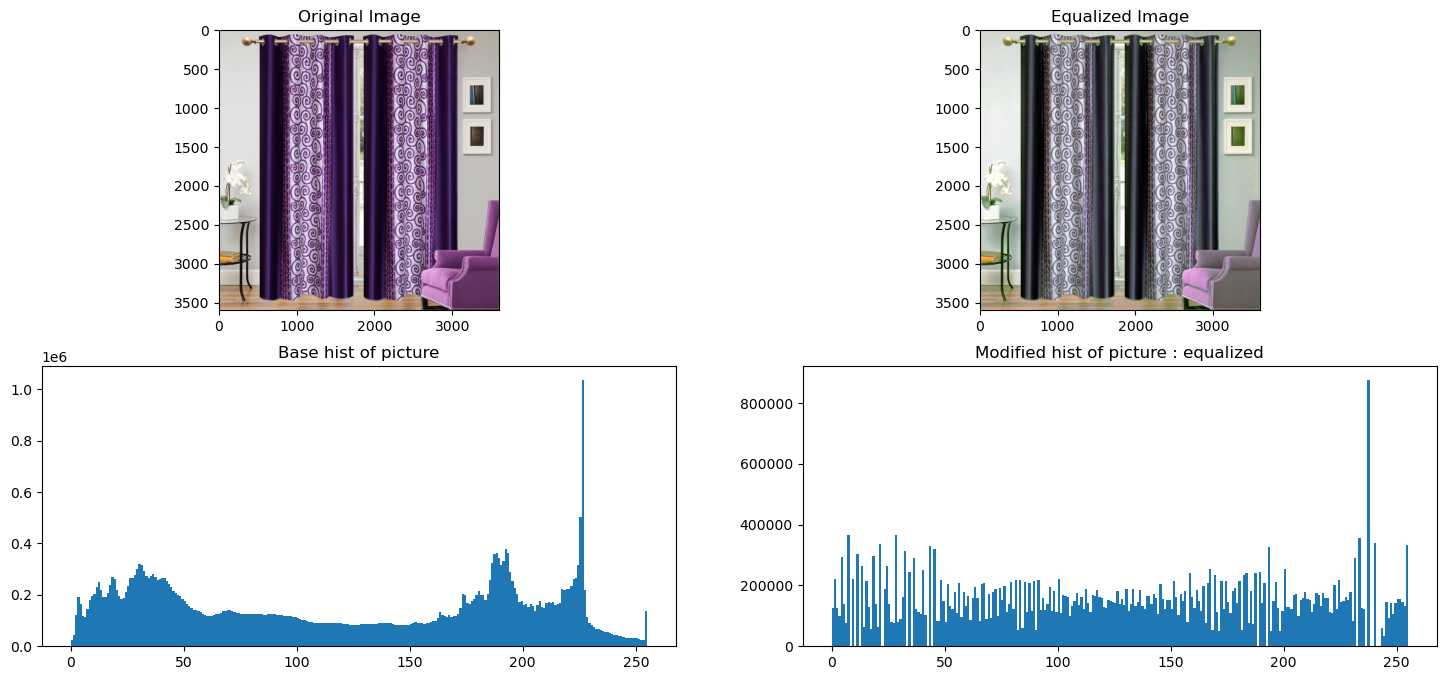

In [250]:
# Equalizer
img2 = PIL.ImageOps.equalize(img)

# All in one box
fig, ax = plt.subplots(2, 2, figsize=(18, 8))

ax[0, 0].imshow(img)
ax[0, 0].set_title('Original Image')

ax[0, 1].imshow(img2)
ax[0, 1].set_title('Equalized Image')

n, bins, patches = ax[1, 0].hist(mat.flatten(), bins=range(256))
ax[1, 0].set_title('Base hist of picture')

mat2 = np.array(img2)
n, bins, patches = ax[1, 1].hist(mat2.flatten(), bins=range(256))
ax[1, 1].set_title('Modified hist of picture : equalized')

plt.show()

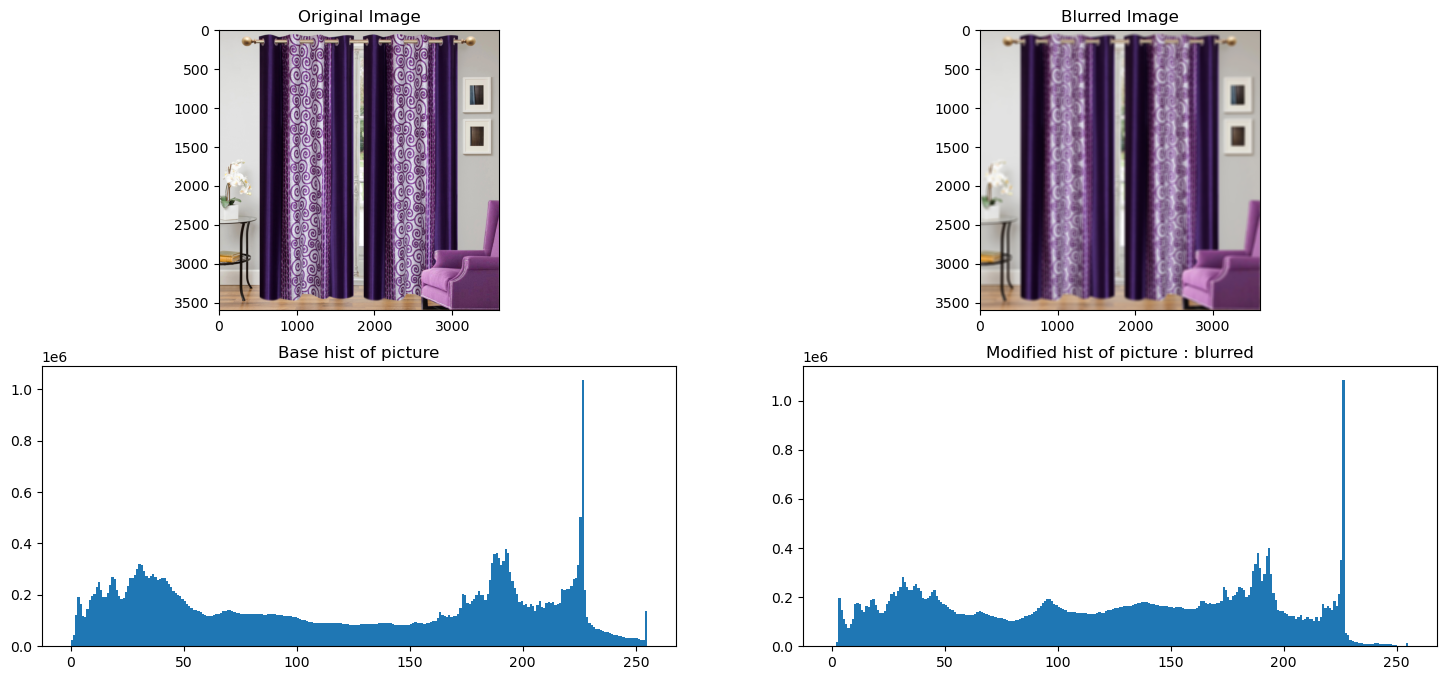

In [251]:
# blurring
img2 = img.filter(ImageFilter.BoxBlur(radius=20)) #takes 20 pixel in each direction do box blur

# All in one box
fig, ax = plt.subplots(2, 2, figsize=(18, 8))
ax[0, 0].imshow(img)
ax[0, 0].set_title('Original Image')
ax[0, 1].imshow(img2)
ax[0, 1].set_title('Blurred Image')

n, bins, patches = ax[1, 0].hist(mat.flatten(), bins=range(256))
ax[1, 0].set_title('Base hist of picture')

mat2 = np.array(img2)
n, bins, patches = ax[1, 1].hist(mat2.flatten(), bins=range(256))
ax[1, 1].set_title('Modified hist of picture : blurred')

plt.show()

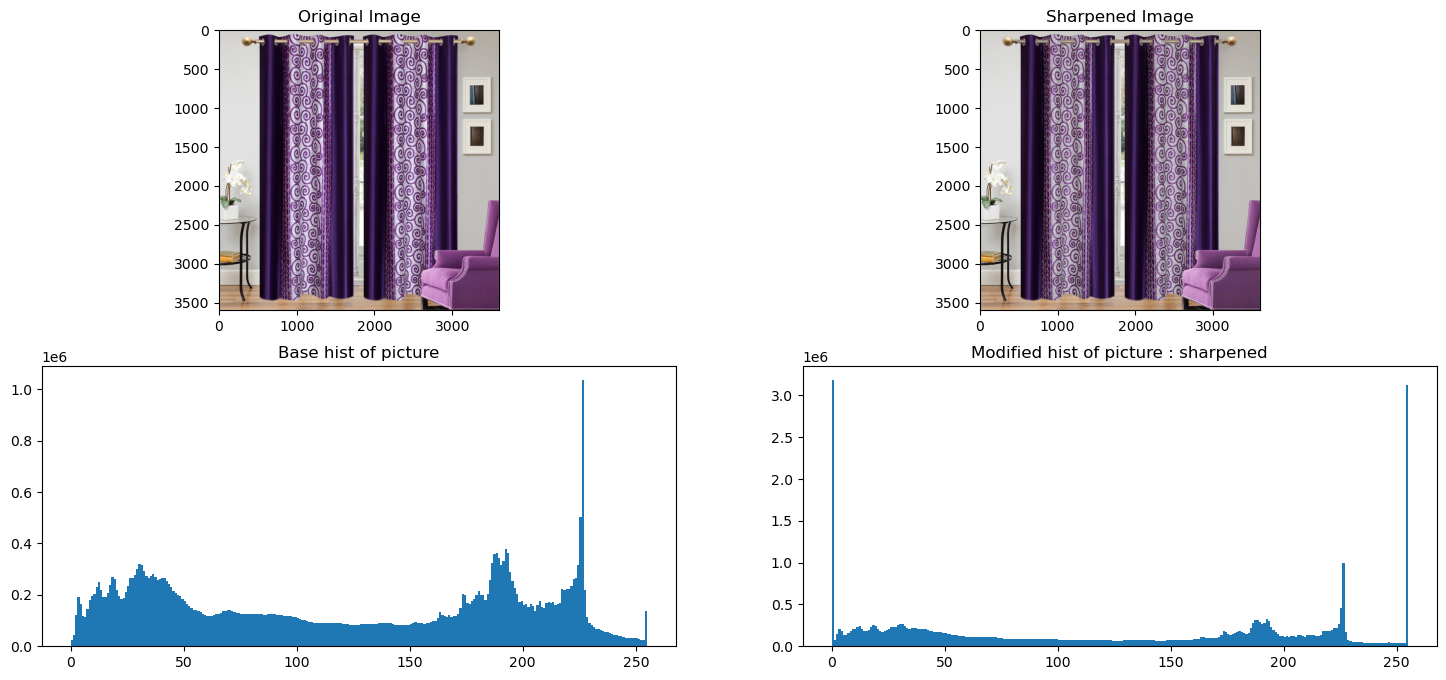

In [252]:
#sharpened
enhancer = PIL.ImageEnhance.Sharpness(img)
img2 = enhancer.enhance(20)

# All in one box
fig, ax = plt.subplots(2, 2, figsize=(18, 8))
ax[0, 0].imshow(img)
ax[0, 0].set_title('Original Image')
ax[0, 1].imshow(img2)
ax[0, 1].set_title('Sharpened Image')

n, bins, patches = ax[1, 0].hist(mat.flatten(), bins=range(256))
ax[1, 0].set_title('Base hist of picture')

mat2 = np.array(img2)
n, bins, patches = ax[1, 1].hist(mat2.flatten(), bins=range(256))
ax[1, 1].set_title('Modified hist of picture : sharpened')

plt.show()

### SIFT Treating : Descriptors extraction

In [254]:
list_photos = data_img['img_path']
type(list_photos)

pandas.core.series.Series

In [255]:
#len(sift_keypoints[0])

In [256]:

""" Calculate SIFT keypoints and descriptors for an image and plot results
  Parameters
  ----------
  img : an image object, to which SIFT will be applied
  plot : boolean value, to determine wether plot must be made or not
"""
"""# Sabrine's version 

def apply_sift_and_plot(img,plot=True):

  img_as_array=np.array(img)
  sift = cv2.SIFT_create()
  keypoints, descriptor = sift.detectAndCompute(img_as_array, None) #keep None to detect&compute all image pixels and not a specific area
  gray = cv2.cvtColor(img_as_array, cv2.COLOR_BGR2GRAY)
  if plot:
    print('Number of keypoints = ',len(keypoints))
    res = cv2.drawKeypoints(gray,keypoints,img_as_array,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(15,10))
    plt.imshow(res)
    plt.show()
  return keypoints,descriptor
"""

"# Sabrine's version \n\ndef apply_sift_and_plot(img,plot=True):\n\n  img_as_array=np.array(img)\n  sift = cv2.SIFT_create()\n  keypoints, descriptor = sift.detectAndCompute(img_as_array, None) #keep None to detect&compute all image pixels and not a specific area\n  gray = cv2.cvtColor(img_as_array, cv2.COLOR_BGR2GRAY)\n  if plot:\n    print('Number of keypoints = ',len(keypoints))\n    res = cv2.drawKeypoints(gray,keypoints,img_as_array,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)\n    plt.figure(figsize=(15,10))\n    plt.imshow(res)\n    plt.show()\n  return keypoints,descriptor\n"

In [257]:
# List of images with keypoints and descriptors

# prep lists
img_list=[]
keypoints_list=[]
descriptors_list=[]

# prep SIFT
sift = cv2.SIFT_create()

# extract keypoints and descriptors and append into lists
for path in list_photos :
    img = Image.open(path)
    img = PIL.ImageOps.equalize(img) #img treatment
    img_list.append(img)
    img_as_array=np.array(img)
    keypoints, descriptors = sift.detectAndCompute(img_as_array, None)
    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)
    
#430 secs to run
#C:\Users\kanam\anaconda3\Lib\site-packages\PIL\Image.py:3218: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  #warnings.warn(

C:\Users\kanam\anaconda3\Lib\site-packages\PIL\Image.py:3218: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [258]:
# Now we concatenate all this to treat it all at once
desc_all = np.concatenate(descriptors_list)
desc_all.shape

(11114842, 128)

In [259]:
# Determination number of DESCRIPTORS clusters
k = int(round(np.sqrt(len(desc_all)),0))
print("Estimated number of clusters : ", k)
print("Creating",k, "descriptors clusters  ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(desc_all)

#took 350 seconds

Estimated number of clusters :  3334
Creating 3334 descriptors clusters  ...


C:\Users\kanam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 8192 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


MiniBatchKMeans(init_size=10002, n_clusters=3334, random_state=0)

### Bag of Virtual Words

In [261]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("error with image number  : ", image_num) # error check
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(descriptors_list) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1 = np.round(time.time()-temps1, 2)
print(f"Creation of histograms took : {duration1} seconds")

0
100
200
300
400
500
600
700
800
900
1000
Creation of histograms took : 93.07 seconds


In [262]:
#total des histogrames de l'image
im_features.shape

(1050, 3334)

### Dimensions reduction

In [264]:
#PCA reduction
print("Dataset dimensions dataset before PCA : ", im_features.shape)
pca = PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dataset dimensions after PCA : ", feat_pca.shape)

Dataset dimensions dataset before PCA :  (1050, 3334)
Dataset dimensions after PCA :  (1050, 733)


In [265]:
#t-SNE reduction
tsne = TSNE(n_components=2, perplexity=0.2, 
                     n_iter=2000, init='random', random_state=6)
img_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(img_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data_img["category"]
print(df_tsne.shape)

(1050, 3)


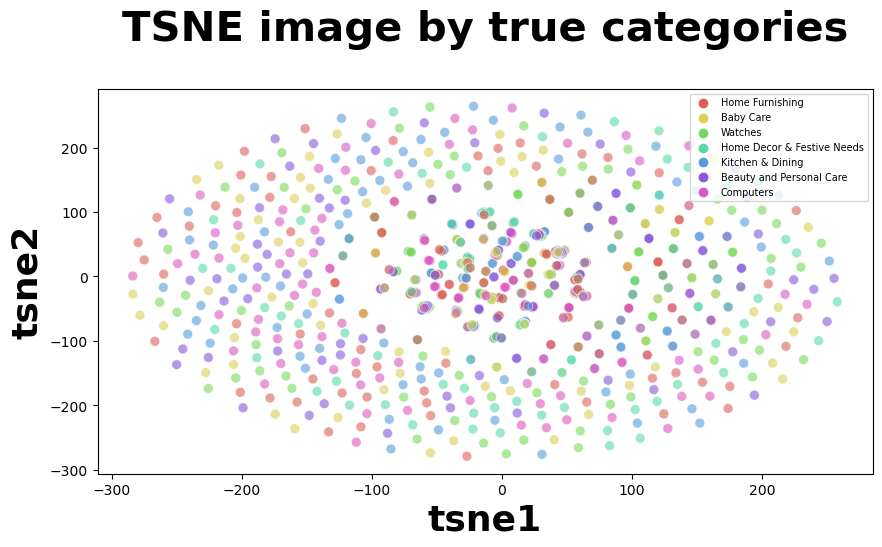

In [266]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    x="tsne1", 
    y="tsne2", 
    hue="class", 
    data=df_tsne, 
    legend="brief",
    palette=sns.color_palette('hls', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE image by true categories', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 7}) 

plt.show()


### Clusterization from img histograms features reduced

In [268]:
# use kmeans and image tsne 
kmeans_img = KMeans(n_clusters=7, n_init=100 ,random_state=42, init='k-means++')
kmeans_img.fit(img_tsne)

C:\Users\kanam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


KMeans(n_clusters=7, n_init=100, random_state=42)

In [269]:
df_tsne["sift_cluster"] = kmeans_img.labels_
print(df_tsne.shape)

(1050, 4)


In [270]:
# Evaluate the ARI
ari_sift_clustering = adjusted_rand_score(data['general_category'], df_tsne['sift_cluster'])
print('Similarity score :',ari_sift_clustering)

Similarity score : 0.00042053977583056206


It looks extremly low ... \
maybe clusterization wasn't done properly ? \
maybe it's not good at all ?

### CNN approach

#### VGG16 model

In [274]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [275]:
def create_model_fct() :
    # Get pre-trained model
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Keep pre-trained weights
    for layer in model0.layers:
        layer.trainable = False

    # Get output
    x = model0.output
    # Complete model
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # New model
    model = Model(inputs=model0.input, outputs=predictions)
    # compile new model 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [276]:
#model = create_model_fct()

In [277]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [278]:
images_features = []
i=0 

start = time.time()

for image_file in list_photos :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

end = np.round(time.time()-start, 2)
print(f"It took {end} seconds")

0
100
200
300
400
500
600


C:\Users\kanam\anaconda3\Lib\site-packages\PIL\Image.py:3218: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000
It took 276.06 seconds


In [279]:
# PCA reduction
print(images_features.shape)
pca = PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


In [280]:
# t-SNE reduction
temps1 = time.time()
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
VGG16_tsne = tsne.fit_transform(feat_pca)

duration1 = np.round(time.time()-temps1, 2)
print(f"T-SNE time : {duration1} seconds")

T-SNE time : 3.77 seconds


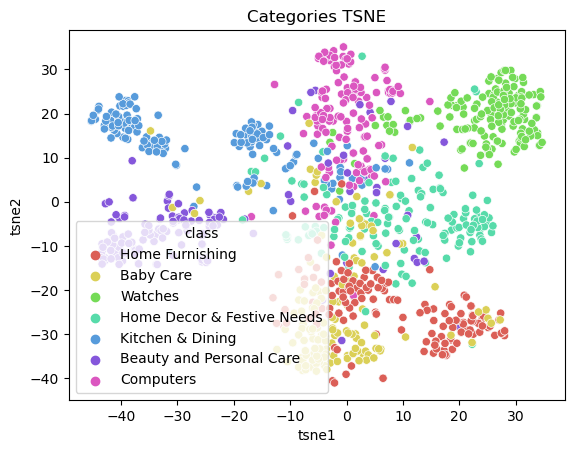

In [281]:
df_tsne = pd.DataFrame(VGG16_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data_img["category"]

sns.scatterplot(
    x="tsne1", 
    y="tsne2", 
    hue="class", 
    data=df_tsne, 
    legend="brief",
    palette=sns.color_palette('hls', n_colors=7))

plt.title('Categories TSNE')
 

plt.show()

In [282]:
# use kmeans and image tsne 
kmeans_VGG16 = KMeans(n_clusters=7, n_init=100 ,random_state=42, init='k-means++')
kmeans_VGG16.fit(VGG16_tsne)

df_tsne["VGG16_cluster"] = kmeans_VGG16.labels_
print(df_tsne.shape)

C:\Users\kanam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


(1050, 4)


In [283]:
df_tsne.head()

tsne1      tsne2            class  VGG16_cluster
0  18.479572 -31.331760  Home Furnishing              0
1   4.776824 -22.056528        Baby Care              5
2  -1.364905 -22.684177        Baby Care              5
3  15.440402 -24.294262  Home Furnishing              0
4  22.107546 -23.676455  Home Furnishing              0

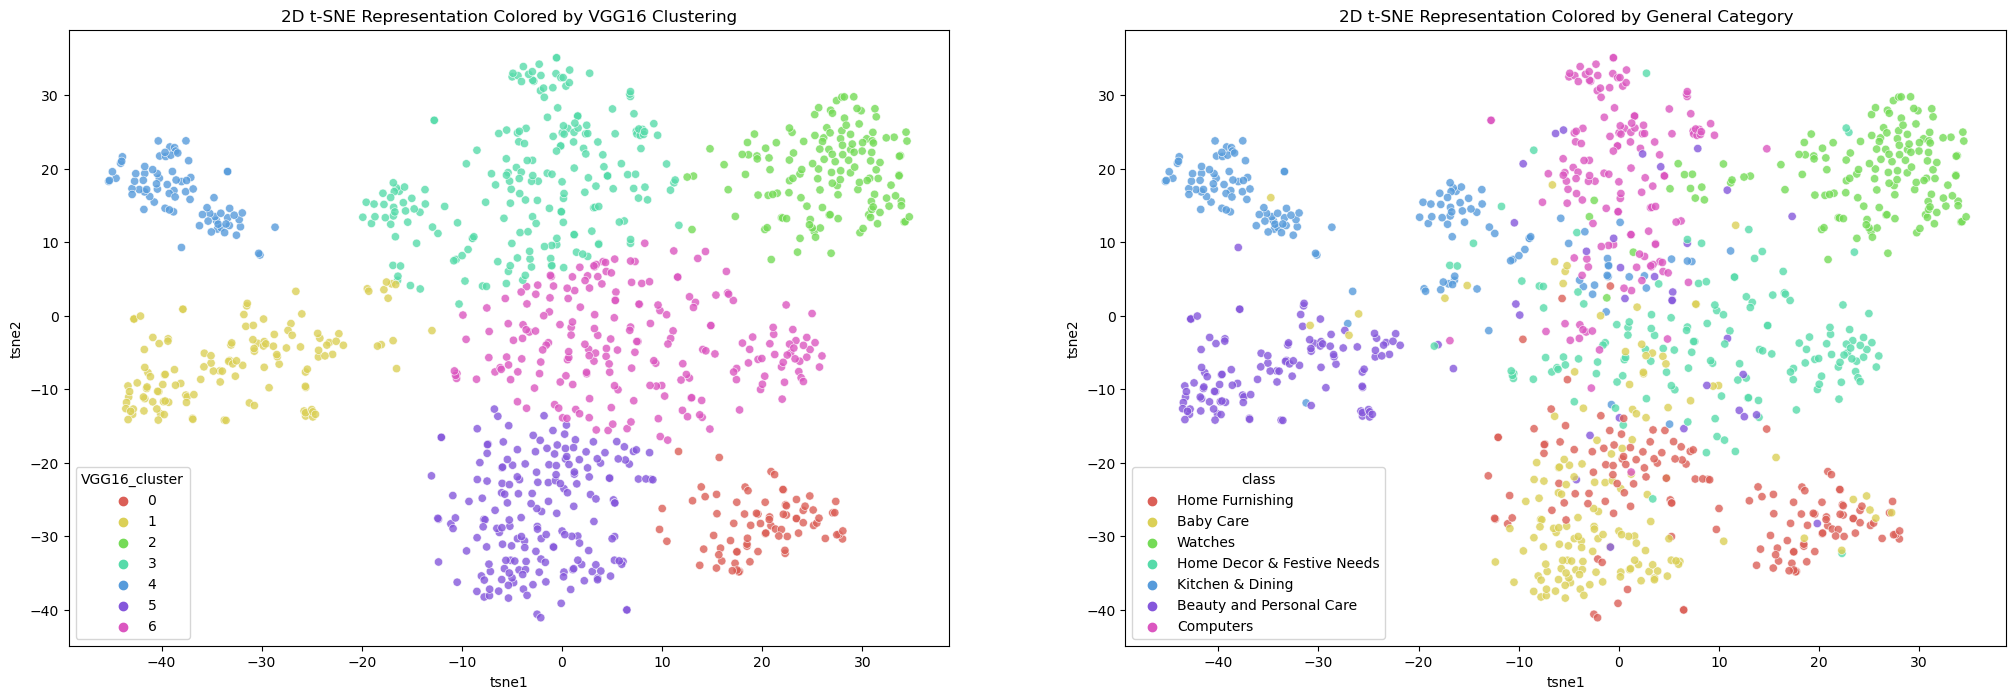

In [284]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

# real categories
sns.scatterplot(
    ax=ax[1],
    x='tsne1', y='tsne2',
    hue='class',
    palette=sns.color_palette('hls', len(df_tsne['class'].unique())),
    data=df_tsne,
    legend='full',
    alpha=0.8
)
ax[1].set_title('2D t-SNE Representation Colored by General Category')

# VGG16 Kmeans clusters
sns.scatterplot(
    ax=ax[0],
    x='tsne1', y='tsne2',
    hue='VGG16_cluster',
    palette=sns.color_palette('hls', len(df_tsne['VGG16_cluster'].unique())),
    data=df_tsne,
    legend='full',
    alpha=0.8
)
ax[0].set_title('2D t-SNE Representation Colored by VGG16 Clustering')


plt.show()

In [285]:
# Evaluate the ARI
ari_VGG16_clustering = adjusted_rand_score(df_tsne['class'], df_tsne['VGG16_cluster'])
print('Similarity score :',ari_VGG16_clustering)

Similarity score : 0.49467635754231043


Almost 0.5 \
Maybe not enough data ? 

This feasability study seems to prove that without any data augmentation, project wouldn't be stable. 

However, if data augmentation were to be included, project would be viable over 50% 

We will move on to our next notebook, in which we will classify our images with Transfer learning on VGG16